# Predictive Model for Early Adoption of Pets within the First Month on Petfinder

## Business Problem:  
How can we utilize the available metadata from online pet profiles on PetFinder.my to develop predictive algorithms that assess the likelihood of a pet being adopted quickly? An effective solution will not only support shelters and rescuers in optimizing their pet profiles but also assist adoption centers and individuals in anticipating the duration of pets' stays. This predictive insight will aid in planning for their stay, estimating food requirements, and potentially seeking foster homes for them until permanent adoption. The overarching goal is to reduce animal suffering and euthanization rates while improving operational efficiency for adoption centers.

## Dataset:  
The data I used for this exercise is sourced from pet listings on PetFinder that has been posted as a [Kaggle challenge](https://www.kaggle.com/competitions/petfinder-adoption-prediction/data). It includes 14993 classified into 5 groups according to their adoption speed.  
for the purpose of this excercise I reclassified the data into just two classes:  
- **class 1** - Adopted within 1 month of listing
- **class 0** - Not adopted within 1 month of listing

While the original dataset encompasses text, tabular, and image data formats, for the purpose of this exercise, only the tabular data will be utilized.  

Below is the description of the data columns:  
### Target Value Description:
AdoptionSpeed: Categorical speed of adoption. Lower is faster. This is the value to predict.

### Variables Description:

- **Type** - Type of animal 
  - 1 = Dog
  - 2 = Cat
  
- **Name** - Name of pet (Empty if not named)

- **Age** - Age of pet when listed, in months

- **Breed1, Breed2** - Primary and Secondary breed of pet (if mixed)
  * Refer to BreedLabels dictionary

- **Gender** - Gender of pet
  - 1 = Male
  - 2 = Female
  - 3 = Mixed (if profile represents group of pets)

- **Color1, Color2, Color3** 
  * Refer to ColorLabels dictionary

- **MaturitySize** - Size at maturity
  - 1 = Small
  - 2 = Medium
  - 3 = Large
  - 4 = Extra Large
  - 0 = Not Specified

- **FurLength** - Fur length
  - 1 = Short
  - 2 = Medium
  - 3 = Long
  - 0 = Not Specified

- **Vaccinated** - Pet has been vaccinated 
  - 1 = Yes
  - 2 = No
  - 3 = Not Sure

- **Dewormed** - Pet has been dewormed
  - 1 = Yes
  - 2 = No
  - 3 = Not Sure

- **Sterilized** - Pet has been spayed / neutered
  - 1 = Yes
  - 2 = No
  - 3 = Not Sure

- **Health** - Health Condition 
  - 1 = Healthy
  - 2 = Minor Injury
  - 3 = Serious Injury
  - 0 = Not Specified

- **Quantity** - Number of pets represented in profile

- **Fee** - Adoption fee (0 = Free)

- **VideoAmt** - Total uploaded videos for this pet

- **PhotoAmt** - Total uploaded photos for this pet

It's worth noting that occasionally, a single profile might represent a group of pets; in such instances, the adoption speed is gauged based on the time taken for the entire group of pets to be adopted.


## Methods

For this project, given the binary nature of the target variable, I primarily focused on two classification algorithms: Decision Trees and Logistic Regression.

1. **Decision Tree (Baseline Model):** I initiated with a Decision Tree as the baseline model to set a foundational benchmark for performance.
   
2. **Tuned Decision Tree:** Building upon the baseline, I proceeded to fine-tune the hyperparameters of the Decision Tree, aiming for enhanced predictive capabilities.
   
3. **Logistic Regression:** To diversify and potentially refine our predictions, I implemented the Logistic Regression model.
   
4. **Tuned Logistic Regression:** To further optimize our results, the Logistic Regression model underwent hyperparameter tuning, ensuring peak accuracy in predictions.

5. **Feature Importance Evaluation:** After tuning both models, I evaluated the feature importance for each. By identifying and cross-referencing the significant features from both models, I extracted the common influential features.

6. **Refined Model with Selected Features:** Leveraging these common important features, I trained a more streamlined model. The objective was to maintain, if not improve, the accuracy of predictions while utilizing fewer columns. This approach not only boosts model efficiency but also reduces processing time and computational power requirements.

### Evaluation Metric:

For the assessment of our models, we will primarily utilize the **accuracy** metric. This choice stems from our objective where both positive and negative outcomes are of equal importance to us. Thus, a model's ability to correctly predict overall instances, whether positive or negative, is pivotal in determining its effectiveness.


## Importing libraries

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, \
                             confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, log_loss
from sklearn.linear_model import LogisticRegression
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
import time

## Loading the data

In [2]:
df = pd.read_csv('data/train.csv')
df.shape

(14993, 24)

### Exploring the data

First I dropped unnecessary columns

In [3]:
df.columns

Index(['Type', 'Name', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
       'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'RescuerID',
       'VideoAmt', 'Description', 'PetID', 'PhotoAmt', 'AdoptionSpeed'],
      dtype='object')

In [4]:
# Drop Name, RescuerID, Description, & PetID
df.drop(['Name', 'RescuerID', 'Description', 'PetID'], axis=1, inplace=True)

Reclassifiy the target value into two classes 0 & 1

1 is adopted within the first month, 0 is not

In [5]:
# Reclassify the data : 
#       class 1 are pets adopted within the first month
#       class 0 are pets not adopted in their first month 
df.loc[(df['AdoptionSpeed']<=2),'AdoptionSpeed'] = 1
df.loc[(df['AdoptionSpeed']>2),'AdoptionSpeed'] = 0

In [6]:
df.describe()

,Type,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,VideoAmt,PhotoAmt,AdoptionSpeed
count,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000
mean,1.457614,10.452078,265.272594,74.009738,1.776162,2.234176,3.222837,1.882012,1.862002,1.467485,1.731208,1.558727,1.914227,1.036617,1.576069,21.259988,41346.028347,0.056760,3.889215,0.502701
std,0.498217,18.155790,60.056818,123.011575,0.681592,1.745225,2.742562,2.984086,0.547959,0.599070,0.667649,0.695817,0.566172,0.199535,1.472477,78.414548,32.444153,0.346185,3.487810,0.500009
min,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,41324.000000,0.000000,0.000000,0.000000
25%,1.000000,2.000000,265.000000,0.000000,1.000000,1.000000,0.000000,0.000000,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,0.000000,41326.000000,0.000000,2.000000,0.000000
50%,1.000000,3.000000,266.000000,0.000000,2.000000,2.000000,2.000000,0.000000,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,0.000000,41326.000000,0.000000,3.000000,1.000000
75%,2.000000,12.000000,307.000000,179.000000,2.000000,3.000000,6.000000,5.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,0.000000,41401.000000,0.000000,5.000000,1.000000
max,2.000000,255.000000,307.000000,307.000000,3.000000,7.000000,7.000000,7.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,20.000000,3000.000000,41415.000000,8.000000,30.000000,1.000000


In [7]:
df['AdoptionSpeed'].value_counts()

AdoptionSpeed
1    7537
0    7456
Name: count, dtype: int64

**The data is already balanced**

## Creating functions to evaluate model performance

In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model(y_test, y_pred, y_pred_proba, fig_title):
    
    # Accuracy
    acc = accuracy_score(y_test, y_pred)
    print("\033[1m" + f"Accuracy: {acc:.4f}" + "\033[0m")


    # Precision, Recall, and F1-Score
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f"Precision: {precision:.4f}\nRecall: {recall:.4f}\nF1-Score: {f1:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"Confusion Matrix:\n{cm}")

    # ROC Curve and AUC for binary class
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])
    roc_auc = auc(fpr, tpr)

    # Plotting the ROC curve
    plt.figure()
    plt.plot(fpr, tpr, lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{fig_title} ROC curve')
    plt.legend(loc="lower right")
    plt.savefig(f"Pictures/{fig_title}.png")
    plt.show()


## 1. Decision Tree (Baseline Model)

In [9]:
X = df.drop('AdoptionSpeed', axis=1)
y = df['AdoptionSpeed']

##### Split the data into train and test

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=42)

In [11]:
baseline_model = DecisionTreeClassifier(random_state=42)
baseline_model.fit(X_train, y_train)

y_pred_baseline = baseline_model.predict(X_test)
y_pred_proba = baseline_model.predict_proba(X_test)

### Metrics of the baseline model

Accuracy: 0.5792
Precision: 0.5901
Recall: 0.5646
F1-Score: 0.5771
Confusion Matrix:
[[876 598]
 [664 861]]


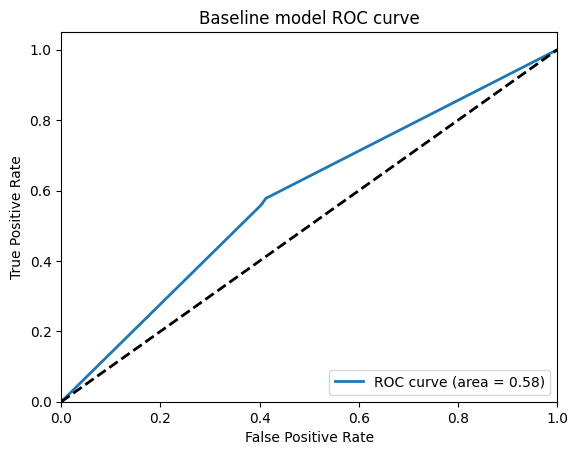

In [12]:
evaluate_model(y_test, y_pred_baseline, y_pred_proba, "Baseline model")

### Confusion matrix of the basline model

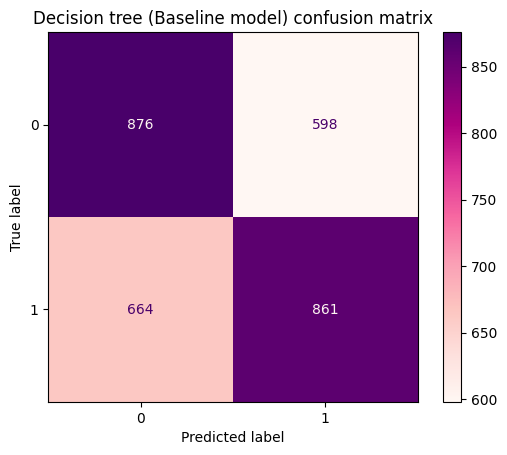

In [13]:
cm = confusion_matrix(y_test, y_pred_baseline)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap='RdPu')
plt.title('Decision tree (Baseline model) confusion matrix')
plt.savefig("Pictures/Decision tree (Baseline model) confusion matrix.png");

Checking the accuracy on the train data

In [14]:
baseline_model.score(X_train, y_train)

0.9909121227280306

**The baseline model is definitely overfitting!**

### Plotting the decision tree

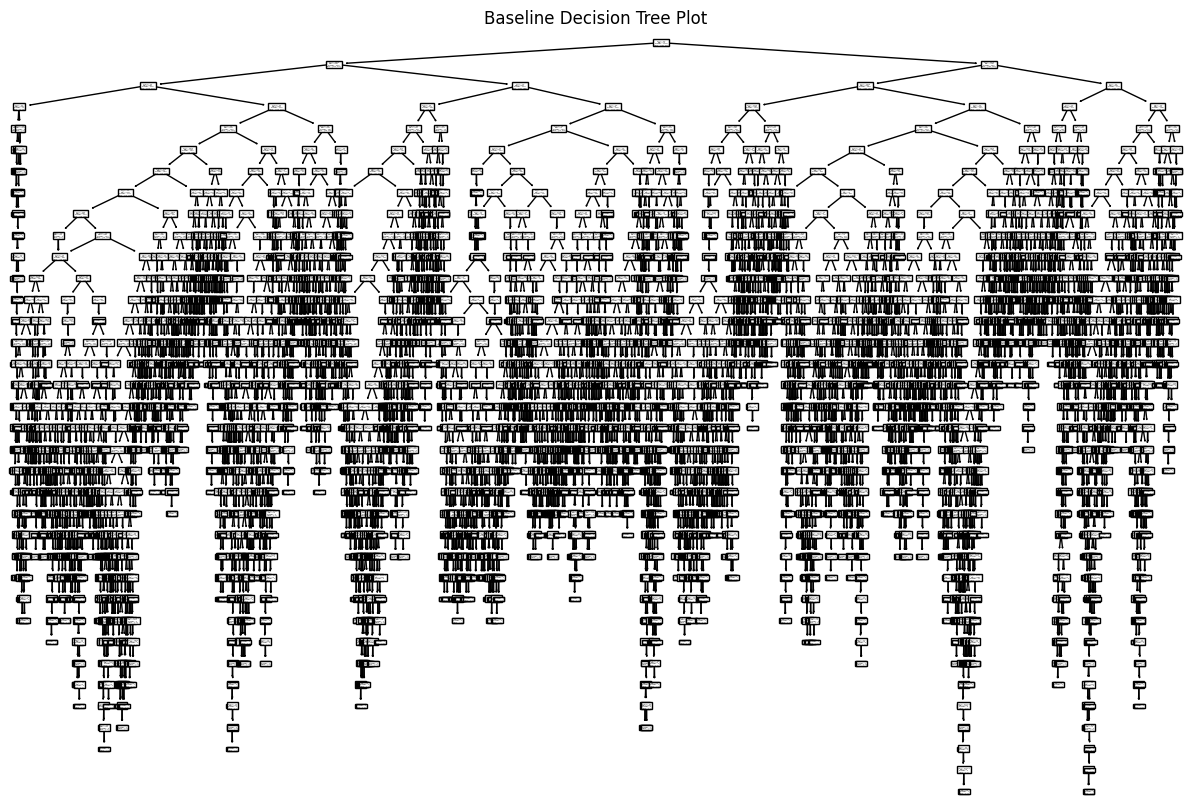

In [15]:
plt.figure(figsize=(15, 10))
plot_tree(baseline_model)
plt.title('Baseline Decision Tree Plot')
plt.show
plt.savefig('Pictures/Decision Tree Plot.png')

## 2. Tuned Decision Tree

In [15]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [4, 5, 6, 7, 8, 9, 10],
    'min_samples_split': [2, 3, 4, 5, 10],
    'min_samples_leaf': [1, 2, 3, 4]
}

# Setting up the grid search
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=10, scoring='accuracy')

# Fitting the grid search object
grid_search.fit(X_train, y_train)

# Extracting best hyperparameters
best_params = grid_search.best_params_

print("Best hyperparameters:")
for key, value in best_params.items():
    print(f"{key}: {value}")

# You can also retrieve the best estimator directly:
best_tree = grid_search.best_estimator_

# Evaluate it on test set if you want
test_score = best_tree.score(X_test, y_test)
print(f"\nAccuracy on test set with best hyperparameters: {test_score:.4f}")

Best hyperparameters:
criterion: gini
max_depth: 7
min_samples_leaf: 1
min_samples_split: 10
splitter: best

Accuracy on test set with best hyperparameters: 0.6419


Accuracy: 0.6419
Precision: 0.6282
Recall: 0.7246
F1-Score: 0.6730
Confusion Matrix:
[[ 820  654]
 [ 420 1105]]


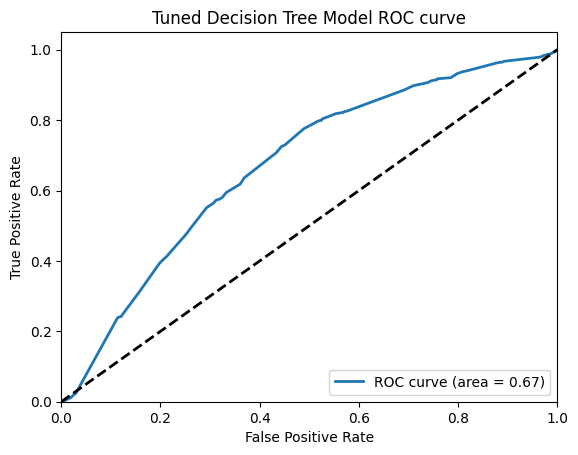

In [16]:
best_tree.fit(X_train, y_train)

y_pred_best_tree = best_tree.predict(X_test)
y_score_best_tree = best_tree.predict_proba(X_test)

evaluate_model(y_test, y_pred_best_tree, y_score_best_tree, 'Tuned Decision Tree Model')

### Confusion matrix of the tuned decision tree

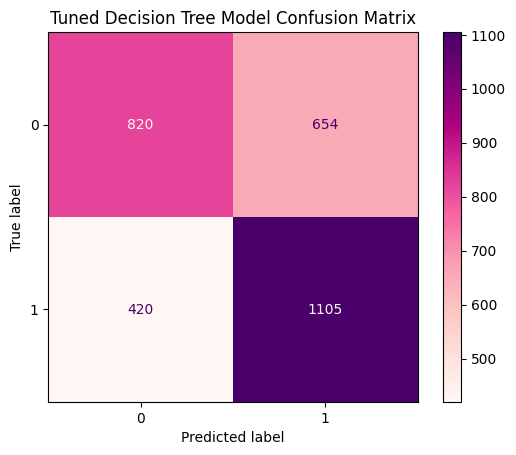

In [18]:
cm = confusion_matrix(y_test, y_pred_best_tree)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap='RdPu');
plt.title('Tuned Decision Tree Model Confusion Matrix')
plt.savefig("Pictures/Tuned Decision Tree Model Confusion Matrix.png");

Checking the accuracy on the train data

In [19]:
best_tree.score(X_train, y_train)

0.6579956644989161

**Similar scores on train and test data so the model is not overfitting**

### Plotting the tuned decision tree

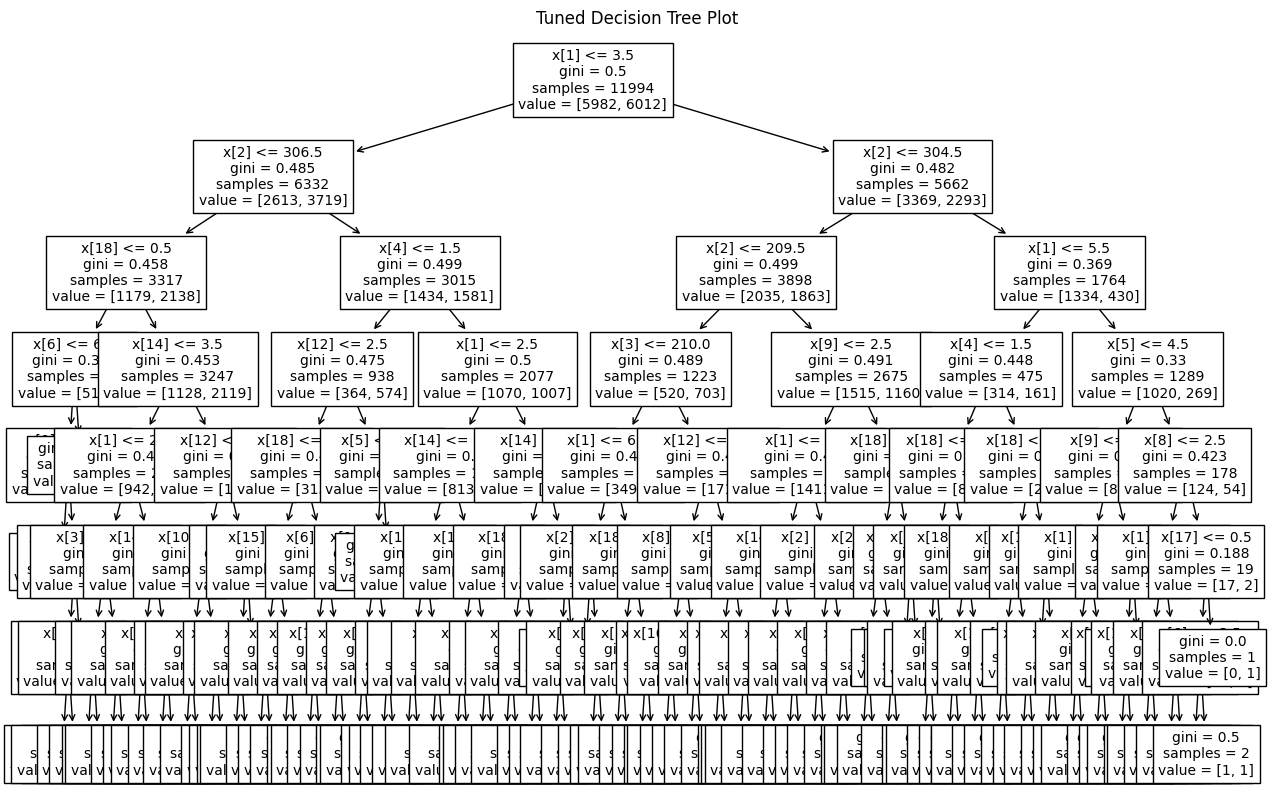

In [20]:
plt.figure(figsize=(15, 10))
plot_tree(best_tree, fontsize=10)
plt.title('Tuned Decision Tree Plot')
plt.show
plt.savefig('Pictures/Tuned Decision Tree Plot.png')

## 3. Logistic regression model

#### Data preprocessing

In [21]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### Training the model

In [22]:
logreg = LogisticRegression(random_state=42, max_iter=10000)
logreg.fit(X_train_scaled, y_train)

y_pred_logreg = logreg.predict(X_test_scaled)
y_score_logreg = logreg.predict_proba(X_test_scaled)

Accuracy: 0.5875
Precision: 0.5929
Recall: 0.6026
F1-Score: 0.5977
Confusion Matrix:
[[843 631]
 [606 919]]


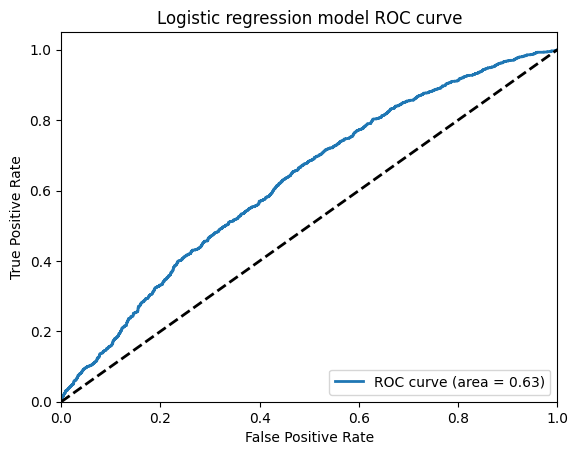

In [23]:
evaluate_model(y_test, y_pred_logreg, y_score_logreg, 'Logistic regression model')

### Confusion matrix of the logistic regression model

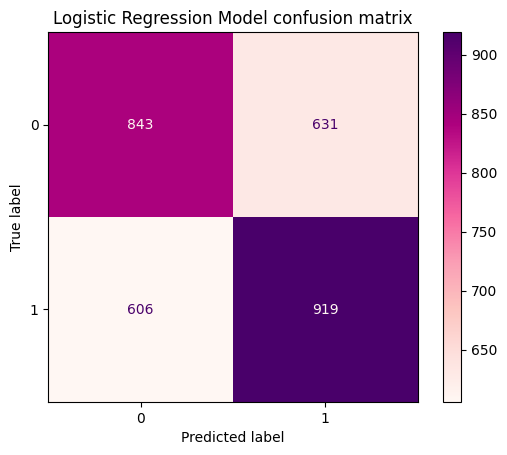

In [24]:
cm = confusion_matrix(y_test, y_pred_logreg)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap='RdPu');
plt.title('Logistic Regression Model confusion matrix')
plt.savefig("Pictures/Logistic Regression Model confusion matrix.png");

checking the score on the train data

In [25]:
logreg.score(X_train_scaled, y_train)

0.5872102718025679

**The model is not overfitting, but lets try to tune the hyperparameters**

## 4. Tuned Logistic Regression

In [26]:
# Define the hyperparameters and their possible values
param_grid = [
    {
        'penalty': ['l1'],
        'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'solver': ['liblinear', 'saga'],
        'tol': [0.0001, 0.001, 0.01, 0.1, 1]
    },
    {
        'penalty': ['l2'],
        'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
        'tol': [0.0001, 0.001, 0.01, 0.1, 1]
    }
]

# Initialize a logistic regression estimator
log_reg_tuning = LogisticRegression(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(log_reg_tuning, param_grid, cv=5, verbose=True, n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_train_scaled, y_train)

# Get the best parameters and estimator
best_params = grid_search.best_params_
best_logreg = grid_search.best_estimator_

print("Best Parameters:", best_params)


Fitting 5 folds for each of 245 candidates, totalling 1225 fits
Best Parameters: {'C': 10, 'penalty': 'l1', 'solver': 'saga', 'tol': 0.1}


In [27]:
y_pred_best_logreg = best_logreg.predict(X_test_scaled)
y_score_best_logreg = best_logreg.predict_proba(X_test_scaled)

Accuracy: 0.5922
Precision: 0.5950
Recall: 0.6203
F1-Score: 0.6074
Confusion Matrix:
[[830 644]
 [579 946]]


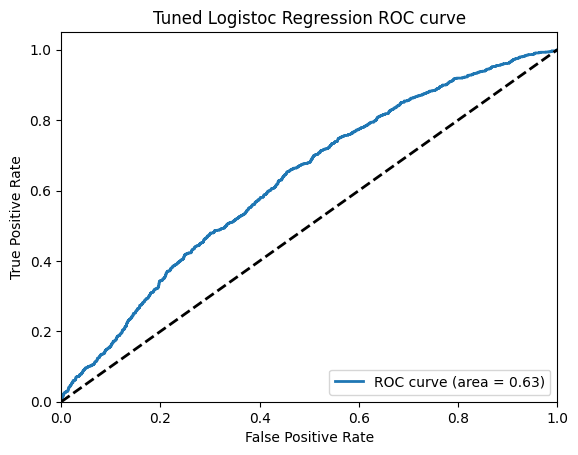

In [28]:
evaluate_model(y_test, y_pred_best_logreg, y_score_best_logreg, 'Tuned Logistoc Regression')

### Confusion matrix of the Tuned logistic regression model

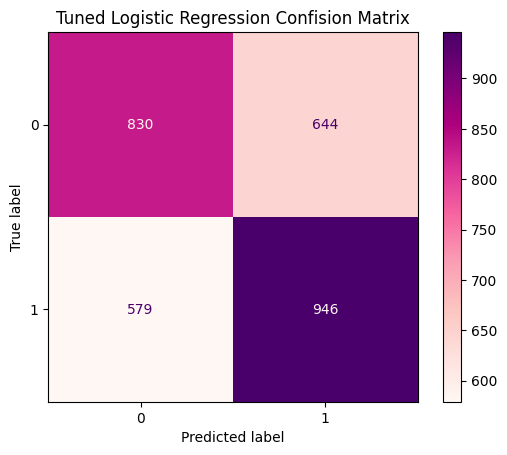

In [29]:
cm = confusion_matrix(y_test, y_pred_best_logreg)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap='RdPu');
plt.title("Tuned Logistic Regression Confision Matrix")
plt.savefig('Pictures/Tuned Logistic Regression Confision Matrix.png')

Checking the model performance on the train data

In [30]:
best_logreg.score(X_train_scaled, y_train)

0.5877938969484743

**Similar scores between train and test data so the model is not overfitting**

## The best model performance is the tuned Decision Tree scoring an Accuracy of 0.6419

## 5. Feature Importance Evaluation

### Tuned logistic regression

In [18]:
# Get the coefficiets
coefficients = best_logreg.coef_[0]

# Create a DataFrame to display them in a table
feature_importance_logreg = pd.DataFrame({'Feature': X.columns, 'Coefficient': coefficients})

# Add a column of the absolute value of the coefficients to sort it
feature_importance_logreg['Importance'] = np.abs(feature_importance_logreg['Coefficient'])

# Print the table
print(feature_importance_logreg.sort_values(by='Importance', ascending=False))

# Put the top 10 features in a list
top_10_logreg = (feature_importance_logreg['Feature'].head(10)).tolist()
top_10_logreg

NameError: name 'best_logreg' is not defined

### Decision tree

In [19]:
# Get the importance values
importance = best_tree.feature_importances_

# Create a DataFrame to display them in a table
feature_importance_tree = pd.DataFrame({'Feature': X.columns,'Importance': importance}).sort_values(by='Importance', ascending=False)

# Print the table
print(feature_importance_tree)

# Put the top 10 features in a list
top_10_tree = (feature_importance_tree['Feature'].head(10)).tolist()
top_10_tree

         Feature  Importance
1            Age    0.301293
2         Breed1    0.280473
18      PhotoAmt    0.100192
14      Quantity    0.049627
3         Breed2    0.048646
12    Sterilized    0.034529
4         Gender    0.029830
15           Fee    0.027520
9      FurLength    0.027414
5         Color1    0.023370
6         Color2    0.023196
8   MaturitySize    0.018921
10    Vaccinated    0.012139
11      Dewormed    0.008440
7         Color3    0.004149
0           Type    0.002889
13        Health    0.002820
16         State    0.002615
17      VideoAmt    0.001938


['Age',
 'Breed1',
 'PhotoAmt',
 'Quantity',
 'Breed2',
 'Sterilized',
 'Gender',
 'Fee',
 'FurLength',
 'Color1']

### Check the common features from the two models

In [33]:
common_elements = list(set(top_10_logreg) & set(top_10_tree))
common_elements

['Age', 'FurLength', 'Color1', 'Gender', 'Breed2', 'Breed1']

**I will run the best performing model again with only these 6 features to see if we can have similar results with less processing**

## 6. Refined Model with Selected Features:

In [34]:
X = df[common_elements]
y = df['AdoptionSpeed']

X_tr, X_te, y_tr, y_te = train_test_split(X, y, random_state=42)

# check time to fit with the 6 common features

start_time = time.time()

best_tree.fit(X_tr, y_tr)

end_time = time.time()
tree_top6_time = end_time - start_time

best_tree_top6_score = best_tree.score(X_te, y_te)

# check time to fit with all features

start_time = time.time()

best_tree.fit(X_train_scaled, y_train)

end_time = time.time()
tree_time = end_time - start_time

best_tree_score = best_tree.score(X_test_scaled, y_test)

print (f'Refined model (6 features) accuracy: {best_tree_top6_score} ; time: {tree_top6_time}')

print (f'All features model accuracy: {best_tree_score} ; time: {tree_time}')

Refined model (6 features) accuracy: 0.6238997065884235 ; time: 0.007245540618896484
All features model accuracy: 0.6418806268756252 ; time: 0.016047000885009766


Accuracy has dropped by two percent, and processing time dropped to one third   
**I will retrain the model with all the top 10 features of the tuned Decision Tree in an attempt to save some of the accuracy**

In [27]:
X = df[top_10_tree]
y = df['AdoptionSpeed']

X_tr, X_te, y_tr, y_te = train_test_split(X, y, random_state=42)

# check time to fit with the 6 common features

start_time = time.time()

best_tree.fit(X_tr, y_tr)

end_time = time.time()
tree_top10_time = end_time - start_time

best_tree_top10_score = best_tree.score(X_te, y_te)

# check time to fit with all features

start_time = time.time()

best_tree.fit(X_train, y_train)

end_time = time.time()
tree_time = end_time - start_time

best_tree_score = best_tree.score(X_test, y_test)

print (f'Refined model accuracy: {best_tree_top10_score} ; time: {tree_top10_time}')

print (f'All features model accuracy: {best_tree_score} ; time: {tree_time}')

Refined model accuracy: 0.6324353160842892 ; time: 0.014003515243530273
All features model accuracy: 0.6418806268756252 ; time: 0.024159669876098633


**Accuracy dropped by less than 1% and the time to fit the model has dropped by half! not bad**

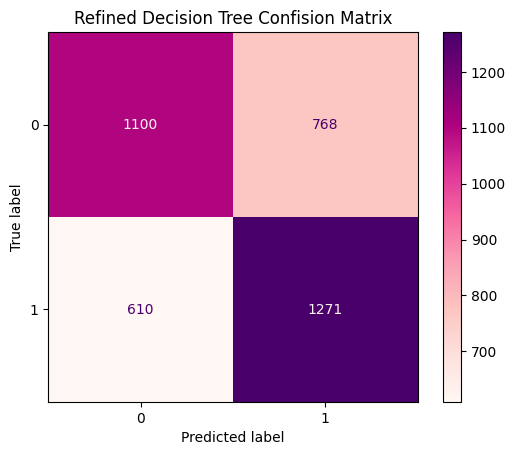

In [36]:
best_tree.fit(X_tr, y_tr)
y_pred_best_tree = best_tree.predict(X_te)
y_pred_prob_best_tree = best_tree.predict_proba(X_te)

cm = confusion_matrix(y_te, y_pred_best_tree)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap='RdPu');
plt.title("Refined Decision Tree Confision Matrix")
plt.savefig('Pictures/Refined Decision Tree Confision Matrix.png')

Accuracy: 0.6324
Precision: 0.6233
Recall: 0.6757
F1-Score: 0.6485
Confusion Matrix:
[[1100  768]
 [ 610 1271]]


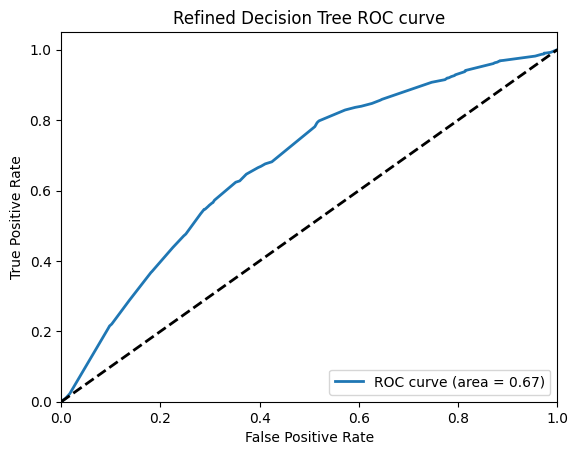

In [37]:
evaluate_model(y_te, y_pred_best_tree, y_pred_prob_best_tree, 'Refined Decision Tree')

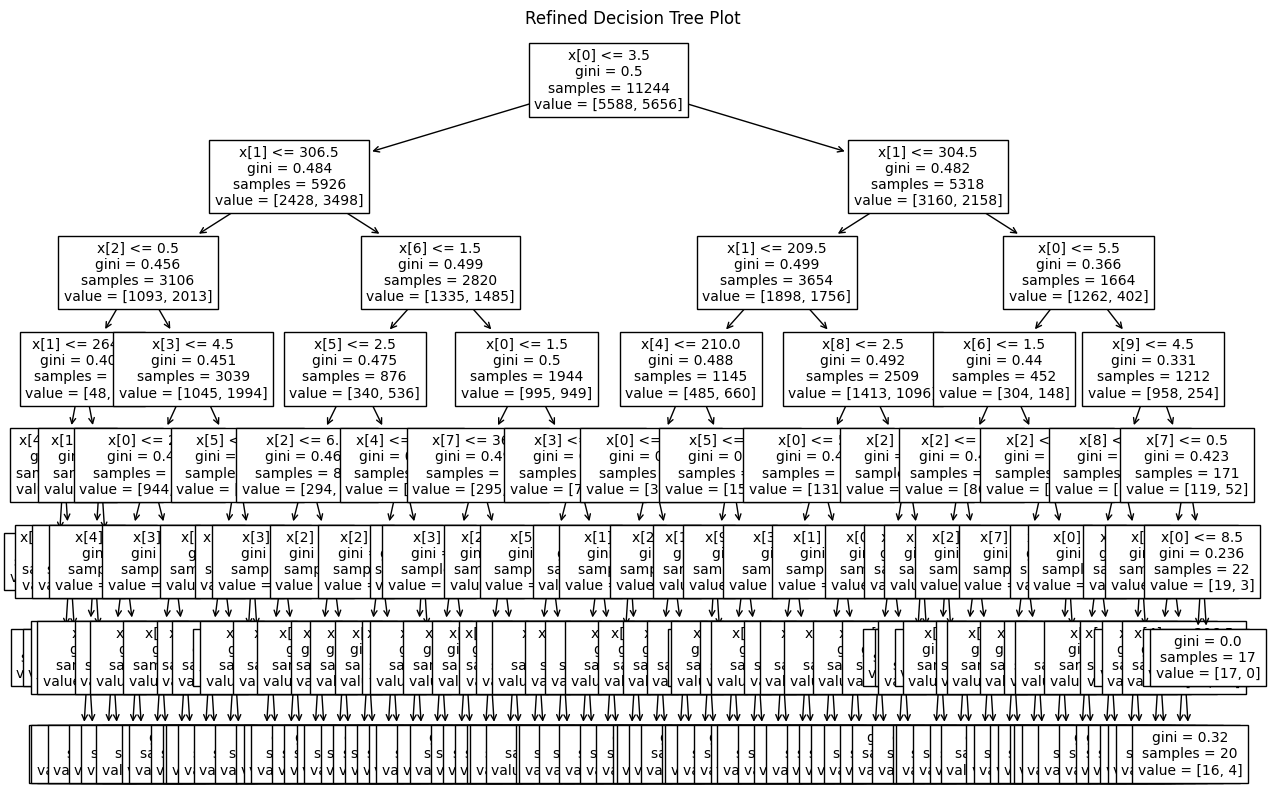

In [38]:
plt.figure(figsize=(15, 10))
plot_tree(best_tree, fontsize=10)
plt.title('Refined Decision Tree Plot')
plt.show
plt.savefig('Pictures/Refined Decision Tree Plot.png')